# Prediction of all sites at once

In [1]:
import json
import requests
from __future__ import print_function
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import re
%matplotlib inline

In [2]:
def run_query(query): # A simple function to use requests to make the API call. Returns json content from query.
    request = requests.get('https://my.es.net/graphql', json={'query': query})
    if request.status_code == 200:
        return request.json()
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))

In [3]:
def query_edge(edge_id, beginTime, endTime):
    query = '''
    {
      mapTopologyEdge(id: "%s") {
            name
        traffic(beginTime: "%s", endTime: "%s")
      }
    }
    ''' % (edge_id, beginTime, endTime)
    
    return  run_query(query)

In [4]:
#Get IDs of all edges in site graph

query_ids = '''
{
  mapTopology(name: "routed_toplevel") {
    edges {
      name
      id
    }
  }
}
'''

result_ids = run_query(query_ids)
print(json.dumps(result_ids, indent=1))

{
 "data": {
  "mapTopology": {
   "edges": [
    {
     "name": "CHIC--STAR", 
     "id": "1767"
    }, 
    {
     "name": "ATLA--NASH", 
     "id": "1747"
    }, 
    {
     "name": "ALBQ--DENV", 
     "id": "1733"
    }, 
    {
     "name": "ALBQ--ELPA", 
     "id": "1734"
    }, 
    {
     "name": "ALBQ--KCP-ALBQ", 
     "id": "1735"
    }, 
    {
     "name": "ALBQ--LANL", 
     "id": "1736"
    }, 
    {
     "name": "ALBQ--SNLA", 
     "id": "1737"
    }, 
    {
     "name": "AMES--STAR", 
     "id": "1738"
    }, 
    {
     "name": "AMST--LOND", 
     "id": "1741"
    }, 
    {
     "name": "AOFA--NEWY", 
     "id": "1744"
    }, 
    {
     "name": "AOFA--STAR", 
     "id": "1745"
    }, 
    {
     "name": "AOFA--WASH", 
     "id": "1746"
    }, 
    {
     "name": "DENV--NGA-SW", 
     "id": "1771"
    }, 
    {
     "name": "ATLA--ORNL", 
     "id": "1748"
    }, 
    {
     "name": "ATLA--WASH", 
     "id": "1751"
    }, 
    {
     "name": "BNL--NEWY", 
     "id": "175

In [5]:
def clean_alledge_data(json_data):
    cleaned_result = json_data['data']['mapTopology']['edges']
    edge_dict = {}
    for item in cleaned_result:
        edge_dict[str(item['id'])] = str(item['name'])
    return edge_dict

edge_dict = clean_alledge_data(result_ids)
edge_names = pd.DataFrame.from_dict(edge_dict, orient='index')
edge_names.columns = ['Name']
edge_names.head()

,Name
1788,JLAB--WASH
1789,KANS--KCP
1780,ELPA--SUNN
1779,ELPA--HOUS
1782,FNAL--STAR


In [6]:
edges = pd.DataFrame(edge_names.Name.str.split('--',1).tolist(), columns = ['From','To'])
edges['ID'] = edge_names.index
edges.head()

,From,To,ID
0,JLAB,WASH,1788
1,KANS,KCP,1789
2,ELPA,SUNN,1780
3,ELPA,HOUS,1779
4,FNAL,STAR,1782


In [7]:
sites_grouped = edges.groupby("To").agg(list)
sites_grouped.head()

,From,ID
To,,
BOST,[AMST],[1739]
CERN-513,"[CERN, AMST]","[1764, 1740]"
CERN-773,"[CERN, CERN-513]","[1763, 1760]"
DENV,"[ALBQ, BOIS]","[1733, 1753]"
ELPA,[ALBQ],[1734]


In [8]:
#Clean data for single edge

def clean_edge_data(json_data):
    #get "traffic" label from json data
    traffic = str(json_data['data']['mapTopologyEdge']['traffic'])

    #get index of "points" label
    index = traffic.find("points")

    #get "points" data
    in_out = traffic[index+len("points: "):].split("],")
    points = [str(item).strip().replace("[", "").replace("]", "").replace(",", "").split() for item in in_out]
    points = points[0:len(points)-1]

    #get labels of points data (ex. CHIC--STAR, STAR--CHIC)
    labels = traffic[traffic.find("labels")+len("labels: "):].split("],")[0].replace("[", 
                                            "").replace("]", "").replace(",", "").replace('"', "").strip().split()
    #Add "Time" to list for header in DataFrame
    labels = ["Time"] + labels
    
    #Create DataFrame
    df = pd.DataFrame(points, columns=labels)
    df = df.astype('float')
    df['Time'] = df['Time'].apply(lambda x: datetime.fromtimestamp(x/1000.))
    
    return df

In [9]:
def sum_incoming_data(siteName, startTime, endTime):
    incoming_edges = sites_grouped.loc[siteName]['ID']
    sites_from = sites_grouped.loc[siteName]['From']
    siteNameData = pd.DataFrame({})
    for index in range(len(incoming_edges)):
        query = query_edge(incoming_edges[index], startTime, endTime)
        try:
            edgeData = clean_edge_data(query)
            siteNameData[sites_from[index]+"--"+siteName] = edgeData[sites_from[index]+"--"+siteName]
        except:
            continue
    sum_data = siteNameData.sum(axis = 1)
    return sum_data

In [10]:
sum_data_allsites = pd.DataFrame({})
for site in sites_grouped.index:
    sum_data = sum_incoming_data(site, "2018-05-17T18:22:53.253Z", "2018-05-21T19:22:53.253Z")
    sum_data_allsites[site] = sum_data
sum_data_allsites.head()

KeyboardInterrupt: 

In [11]:
sum_data_allsites.isna().any()

BOST        False
CERN-513    False
CERN-773     True
DENV        False
ELPA        False
EQX-CHI     False
ETTP        False
HOUS        False
INL         False
KANS        False
KCP          True
KCP-ALBQ     True
LANL        False
LNS         False
LOND        False
LSVN        False
NASH        False
NETL-MGN    False
NETL-PGH    False
NEWY        False
NGA-SW      False
NPS         False
NREL        False
NSO         False
ORAU        False
ORNL        False
OSTI        False
PANTEX      False
PNWG        False
PSFC        False
SACR        False
SAND        False
SNLA        False
SNLL        False
SRS         False
STAR        False
SUNN        False
WASH        False
Y12         False
dtype: bool

In [12]:
sum_data_allsites_cleaned = sum_data_allsites.dropna(axis = 1)
sum_data_allsites_cleaned.head()

,BOST,CERN-513,DENV,ELPA,EQX-CHI,ETTP,HOUS,INL,KANS,LANL,...,PSFC,SACR,SAND,SNLA,SNLL,SRS,STAR,SUNN,WASH,Y12
0,191428.800000,7.688928e+08,3.452268e+08,8.172704e+08,2.832832e+09,8.828165e+07,6.633061e+08,5.914057e+08,3.976760e+10,1.748384e+09,...,1.796640e+07,2.367794e+10,1.857113e+07,2.154364e+09,3.772158e+08,5.624387e+06,1.111336e+11,3.778705e+10,6.549670e+10,1.794482e+08
1,225721.866667,8.499844e+08,3.525691e+08,8.576250e+08,2.489719e+09,8.351908e+07,7.517953e+08,4.796769e+08,3.706494e+10,1.683137e+09,...,1.959473e+07,1.955933e+10,1.595560e+07,2.451831e+09,3.642719e+08,6.267768e+06,1.034257e+11,4.004774e+10,6.293111e+10,1.738443e+08
2,237246.400000,7.672110e+08,3.369151e+08,8.939446e+08,2.567983e+09,5.767751e+07,1.145764e+09,4.540563e+08,3.889328e+10,1.593318e+09,...,1.253788e+08,1.869900e+10,2.086665e+07,2.838914e+09,3.800107e+08,5.320146e+06,1.056454e+11,3.441321e+10,6.283338e+10,1.538670e+08
3,241567.200000,7.364909e+08,4.740085e+08,9.352998e+08,2.716655e+09,5.872293e+07,9.440661e+08,3.657438e+08,3.620096e+10,1.746188e+09,...,6.662454e+08,2.141416e+10,2.187022e+07,2.408067e+09,4.178159e+08,4.259178e+06,1.060835e+11,3.548764e+10,6.386223e+10,1.652354e+08
4,269244.533333,7.022579e+08,5.103909e+08,8.257035e+08,2.138710e+09,5.652351e+07,6.391344e+08,3.902040e+08,2.888252e+10,1.682134e+09,...,3.870411e+08,1.676776e+10,1.908926e+07,2.137541e+09,3.829218e+08,3.192586e+06,1.090908e+11,3.362562e+10,6.443322e+10,1.751421e+08


In [13]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential, model_from_json, Model
from keras.layers import Dense, LSTM, Activation, Dropout, Bidirectional, TimeDistributed, RepeatVector, Input, GRU
#from keras.utils.vis_utils import plot_model
from keras.optimizers import SGD
#from keras.utils import multi_gpu_model
from random import uniform
import json
# Fix AttributeError: 'module' object has no attribute 'control_flow_ops'
import tensorflow
from tensorflow.python.ops import control_flow_ops
tensorflow.control_flow_ops = control_flow_ops

Using TensorFlow backend.


In [14]:
def inverse_transform(pred, traffic_scaler):    
    return traffic_scaler.inverse_transform(pred)

In [15]:
def train_test_multistepnew(df, split_proportion, seq_len_x, seq_len_y, scaler, 
                         traffic_scaler, print_shapes = True):
    #Split features from response variable
    X = df.as_matrix()
    X = scaler.fit_transform(X)
    
    X_train = []
    Y_train = []
    X_test = []
    Y_test = []

    #Train-test split
    row = int(round(split_proportion * df.shape[0]))
    
    #Train Data
    for index in range(row): 
        X_train.append(X[index: index + seq_len_x]) 
        Y_train.append(np.flip(X[index: index + seq_len_x], axis = 0)) #revese target
    
    #Test Data
    for index in range(row + seq_len_x, X.shape[0] - (seq_len_x + seq_len_y + 1)): 
        X_test.append(X[index: index + seq_len_x]) #adding CHIC--STAR
        Y_test.append(X[index + seq_len_x: index + seq_len_x + seq_len_y])

    X_train = np.array(X_train)
    #X_train = X_train.reshape(X_train.shape[0], X_train[0].shape[0])
    Y_train = np.array(Y_train)
    #Y_train = Y_train.reshape(Y_train.shape[0], Y_train[0].shape[0])
    
    X_test = np.array(X_test)
    #X_test = X_test.reshape(X_test.shape[0], X_test[0].shape[0])
    Y_test = np.array(Y_test)
    #Y_test = Y_test.reshape(Y_test.shape[0], Y_test[0].shape[0])

    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], len(df.columns)))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], len(df.columns)))
    #X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
    #X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

    Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], len(df.columns)))
    Y_test = np.reshape(Y_test, (Y_test.shape[0], Y_test.shape[1], len(df.columns)))
    #Y_train = Y_train.reshape(Y_train.shape[0], 1, Y_train.shape[1])
    #Y_test = Y_test.reshape(Y_test.shape[0], 1, Y_test.shape[1])

    if print_shapes:
        print("X_train shape: ", X_train.shape)
        print("Y_train shape: ", Y_train.shape)
        print("X_test shape: ", X_test.shape)
        print("Y_test shape: ", Y_test.shape)
    
    return X_train, Y_train, X_test, Y_test

In [16]:
scaler = MinMaxScaler(feature_range=(0,1))
traffic_scaler = MinMaxScaler(feature_range=(0,1))
X_train, Y_train, X_test, Y_test = train_test_multistepnew(sum_data_allsites_cleaned, 0.87, 
                                                           20, 20, scaler, traffic_scaler)

X_train shape:  (10128, 20, 36)
Y_train shape:  (10128, 20, 36)
X_test shape:  (1452, 20, 36)
Y_test shape:  (1452, 20, 36)


/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  after removing the cwd from sys.path.


In [17]:
batch_size = 24
nb_epoch = 700

model_multivariate_reversed = Sequential()
model_multivariate_reversed.add(LSTM(input_dim = 36, output_dim=150, return_sequences=False))
model_multivariate_reversed.add(RepeatVector(20)) #seq_len_y
model_multivariate_reversed.add(LSTM(output_dim=150, return_sequences=True))
model_multivariate_reversed.add(LSTM(output_dim=150, return_sequences=True))
model_multivariate_reversed.add(TimeDistributed(Dense(36)))  #number of sites

/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: The `input_dim` and `input_length` arguments in recurrent layers are deprecated. Use `input_shape` instead.
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:5: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=False, input_shape=(None, 36))`
  """
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  import sys
/home/kvsingh/anaconda2/envs/carnd-term1/lib/python2.7/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(units=150, return_sequences=True)`
  


In [19]:
print("-- Building --")
model_multivariate_reversed.compile(loss="mse",
                  optimizer = 'adam')

print('-- Training --')
for i in range(nb_epoch):
    model_multivariate_reversed.fit(X_train, Y_train, epochs=1, batch_size=batch_size, shuffle=False)
    model_multivariate_reversed.reset_states()

-- Building --
-- Training --
Epoch 1/1
10128/10128 [==============================] - 40s - loss: 0.0070    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0059    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0057    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0056    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0055    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0054    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0053    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0051    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0050    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0049    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0048    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0047    
Epoch 1/1


10128/10128 [==============================] - 38s - loss: 0.0021    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0021    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0021    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0020    
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0011    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0011    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0011    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0012    
Epoch 1/1
10128/10128 [==============================] - 38s - loss: 0.0011    
Epoch 1/1
10128/10128 [===========================

10128/10128 [==============================] - 37s - loss: 8.6352e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.5573e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 9.3144e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 9.0505e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.9445e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.6010e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.4657e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.7622e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.6460e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.6109e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.5594e-04    
Epoch 1/1
10128/10128 [==============================] - 37s - loss: 8.9731e-04    
Ep

In [21]:
from keras.models import load_model

model_multivariate_reversed.save('model_multivariate_reversed.h5')

In [18]:
# returns a compiled model
# identical to the previous one
model_multivariate_reversed.load_weights('model_multivariate_reversed.h5')

In [44]:
# walk-forward validation on the test data
pred_x_test = model_multivariate_reversed.predict(X_test, batch_size)
print(pred_x_test.shape)
#pred_x_test = np.reshape(pred_x_test, (pred_x_test.shape[0]*pred_x_test.shape[1], 36))
#pred_test = inverse_transform(pred_x_test, scaler)

y_test = np.float_(Y_test)
#y_test = np.reshape(y_test, (y_test.shape[0]*y_test.shape[1], 36))
#y_test_inv = inverse_transform(y_test, scaler)

(1452, 20, 36)


In [48]:
print(Y_test[0][0])
print(pred_x_test[0][0])

[  3.62482755e-01   1.05748908e-01   6.91562910e-03   4.54562121e-02
   4.47754836e-02   3.63019819e-02   6.27900588e-02   4.34225076e-02
   2.13069013e-01   1.07878731e-02   8.38787506e-04   7.16223386e-02
   2.15518378e-02   1.24322888e-01   7.28448151e-02   1.67370593e-03
   3.17067957e-01   3.39933788e-05   3.76810948e-04   2.31839461e-02
   3.23108038e-02   7.07833279e-04   4.91145329e-02   2.09849835e-01
   1.45459987e-01   3.73565279e-02   8.98129600e-03   9.71581083e-02
   1.39028744e-02   5.94115521e-02   2.18965184e-02   3.94909283e-03
   3.55699585e-01   1.46817825e-01   2.83438592e-01   1.46481409e-01]
[ 0.37268308  0.13429523  0.01037513  0.0328621   0.05080712  0.0084328
  0.10551202  0.0365957   0.29672056  0.02331346 -0.00682425  0.0657682
  0.02934236  0.15917936 -0.00099889 -0.00040295  0.29838547  0.00189351
  0.00084409  0.0040852   0.0597986  -0.00766025  0.03644186  0.09889597
  0.18248293  0.07559505  0.00851607  0.16599979  0.01628374  0.06122616
  0.01336148  0

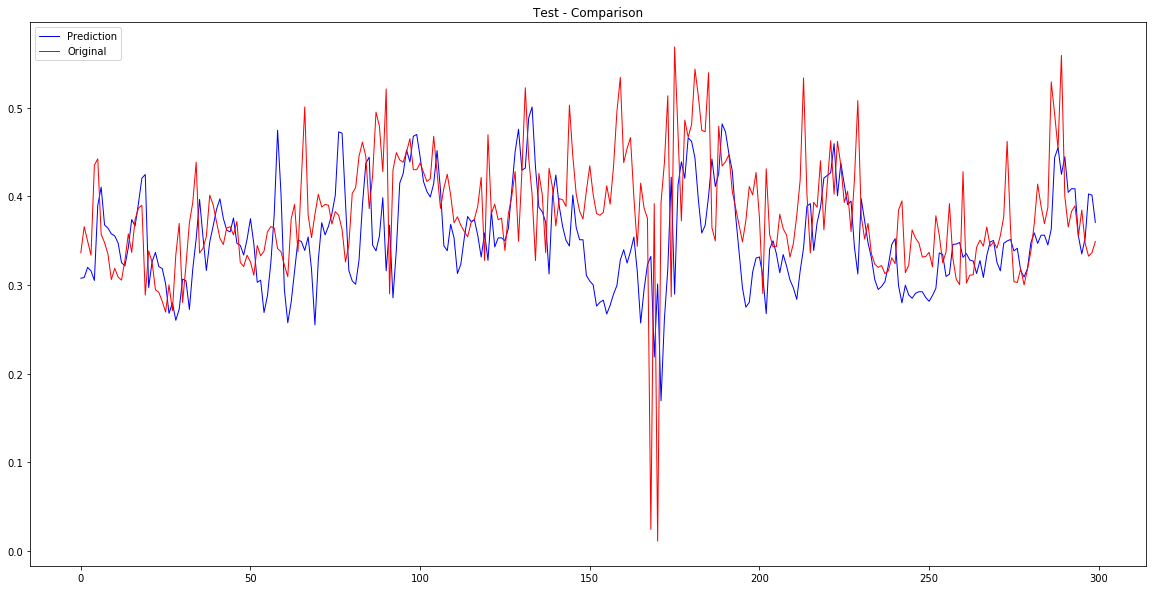

In [57]:
#1 timestep ahead has good prediction

pred_first = [item[0] for item in pred_x_test][700:1000]
pred_first_first = [item[35] for item in pred_first]
y_first = [item[0] for item in y_test][700:1000]
y_first_first = [item[35] for item in y_first]


# line_test_pred = np.reshape(pred_test, pred_test.shape[0])
# line_test_real = np.reshape(y_test_inv, y_test_inv.shape[0])
plt.figure(figsize=(20,10))
plt.plot(pred_first_first, color='blue',label='Prediction', linewidth=1)
plt.plot(y_first_first, color='red',label='Original', linewidth=1)
plt.legend(loc='best')
plt.title('Test - Comparison')
plt.show()